In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import normalize
from PIL import Image as im

import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

!pip install snntorch

# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
device = "cpu"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 kB 4.4 MB/s eta 0:00:00


<ipython-input-10-3a237a213cb5>:24: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/ERPdata.csv')

In [ ]:
meta_df=pd.read_csv('/content/drive/MyDrive/demographic.csv')

In [ ]:
df.head(3)

,subject,condition,Fz,FCz,Cz,FC3,FC4,C3,C4,CP3,CP4,time_ms
0,1,1,5.533701,5.726507,5.469535,5.386723,4.588875,6.560092,4.542811,5.397492,5.103695,-1500.0000
1,1,1,5.651489,5.837326,5.773131,5.627975,4.822217,6.739976,4.811770,5.541357,5.379273,-1499.0234
2,1,1,5.717580,5.932924,5.948466,5.826460,4.979647,7.026199,5.053779,5.634972,5.600504,-1498.0469


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## DATA PREPROCESSING

a. EEG Time series data pre-processing

In [ ]:
data_dict = {}
data_list = []
for i in range(1,82):
    if i==1 or i==6 or i==16 or i==27:
        continue
    df_sub = df[df['subject'] == i]
    for j in range(1,4):
        df_subcon = df_sub[df_sub['condition'] == j]
        df_subcon = df_subcon.drop(['subject','condition','time_ms'],axis=1)
        record = df_subcon.to_numpy()
        record = np.transpose(record)

        record_name = str(i)+str(j)
        data_dict[record_name] = record
    
        record = record.tolist()
#         if i==2 and j==1:
#             print(len(record))
        dummy = []
        dummy.append(record)
        data_list.append(dummy)

c = 0
for key in data_dict.keys():
    c += 1
    #print(data_dict[key].shape)
print(c)

c = 0
for data in data_list:
    c += 1
    #print(len(data))
print(c)

231
231


In [ ]:
labels = []
device = "cpu"

for i,x in enumerate(meta_df[' group'].tolist()):
    if i==1 or i==6 or i==16 or i==27:
        continue
    labels.append(x)
    labels.append(x)
    labels.append(x)
X = torch.Tensor(data_list).to(device)
y = torch.Tensor(labels).to(device)
import torch.nn.functional as F
y = F.one_hot(y.to(torch.int64), num_classes=2)

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [ ]:
y[200][0] == 1

tensor(False)

In [ ]:
X[0].shape

torch.Size([1, 9, 3072])

In [ ]:

for i in range(len(X)):
    img = X[i]
    img = np.reshape(img, (9, 3072))
    img = (img - img.min() ) / ( img.max() - img.min()) * 255
    # img = normalize(img, p=50)
    # print(img.shape)
    # print(img.min(),img.max())
    # cv2.imwrite('test.jpg', img)
    # cv2.imshow("image", img)
    # cv2.waitKey()
    img = np.asarray(img)
    data = im.fromarray(img).convert("L")
    if y[i][0] == 1:
        data.save('/content/drive/MyDrive/ERP_imagedata/0/'+str(i)+'.jpeg')
    else:
        data.save('/content/drive/MyDrive/ERP_imagedata/1/'+str(i)+'.jpeg')


In [ ]:
img=im.open('/content/drive/MyDrive/ERP_imagedata/0/0.jpeg')
img.show()

b. Demographics data pre-processing

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the CSV file into a pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/demographic.csv')

df = df[df['subject'] != 1]
df = df[df['subject'] != 6]
df = df[df['subject'] != 16]
df = df[df['subject'] != 27]
# print(df.head)

# Preprocess the data
# Convert categorical variable to numerical using LabelEncoder
le = LabelEncoder()
df[' gender'] = le.fit_transform(df[' gender'])

# Scale the numerical features using StandardScaler
scaler = StandardScaler()
df[[' age', ' education']] = scaler.fit_transform(df[[' age', ' education']])

# Separate the data into schizophrenia and non-schizophrenia groups
df_schizophrenia = df[df[' group'] == 1]
df_non_schizophrenia = df[df[' group'] == 0]

# Create the input and output data for the ANN model
# The input data consists of the age and education features
# The output data consists of a binary variable indicating schizophrenia diagnosis
X_demo = df[[' age', ' education', ' gender']].to_numpy()
y_demo = df[' group'].to_numpy()

# print(X_demo)

DATALOADER CREATION FOR TRAINING

In [ ]:
class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = "/content/drive/MyDrive/ERP_imagedata/"
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.jpeg"):
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = {"0" : 0, "1": 1}
        self.img_dim = (9, 3072)    
        
    def __len__(self):
        return len(self.data)    
        
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        img = TF.to_tensor(img)
        class_id = self.class_map[class_name]
        # img_tensor = torch.from_numpy(img)
        img_tensor = img
        # img_tensor = TF.to_tensor(img_tensor)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        X_train, X_test = img_tensor[:, 0.8*len(img_tensor)], img_tensor[0.8*len(img_tensor),:]
        y_train, y_test = class_id[:, 0.8*len(img_tensor)], class_id[0.8*len(img_tensor),:]
        return X_train, X_test, y_train, y_test

In [ ]:
dataset = CustomDataset()
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

['/content/drive/MyDrive/ERP_imagedata/0', '/content/drive/MyDrive/ERP_imagedata/1']
[['/content/drive/MyDrive/ERP_imagedata/0/0.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/1.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/2.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/3.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/4.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/5.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/6.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/7.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/8.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/9.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/10.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/11.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/12.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/13.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/14.jpeg', '0'], ['/content/drive/MyDrive/ERP_imagedata/0/15.jpeg', '0'], ['/content/d

NN MODEL

In [ ]:

spike_grad = surrogate.fast_sigmoid(slope=20)
beta = 0.4

lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)


In [ ]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=20)
beta = 0.4
num_steps = 50
batch_size=4

In [ ]:
data, targets = next(iter(data_loader))
data = data.to(device)
targets = targets.to(device)
# print(data[0].shape)
# print(data[0])
for step in range(num_steps):
    # data = TF.to_tensor(data)
    spk_out, mem_out = net(data)

In [ ]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)
  
  return torch.stack(spk_rec), torch.stack(mem_rec)

In [ ]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

In [ ]:
# already imported snntorch.functional as SF 
loss_fn = SF.ce_rate_loss()

In [ ]:
targets = torch.reshape(targets, (-1,))
loss_val = loss_fn(spk_rec, targets)

print(f"The loss from an untrained network is {loss_val.item():.3f}")

The loss from an untrained network is 0.693


In [ ]:
acc = SF.accuracy_rate(spk_rec, targets)

print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The accuracy of a single batch using an untrained network is 25.000%


In [ ]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()
    
    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(data_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        # print(targets.shape)
        targets = torch.reshape(targets, (-1,))
        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
          with torch.no_grad():
              net.eval()

              # Test set forward pass
              test_acc = batch_accuracy(data_loader, net, num_steps)
              print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
              test_acc_hist.append(test_acc.item())

        counter += 1

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:

class NetNN(nn.Module):
    def __init__(self):
        super().__init__()
        beta = 0.5  # neuron decay rate
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient
        self.conv1 = nn.Conv2d(1, 2, (9,48))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(2, 1, 1)
        self.fc1 = nn.Linear(3025, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.shape)
        x = self.fc1(x)
        # print(x.shape)
        x = F.relu(x)
        # print(x.shape)
        x = self.fc2(x)
        x = F.relu(x)
        # print(x.shape)
        x = self.fc3(x)
        # x = self.spike_out(x)
        # print(x.shape)
        return x

net = NetNN()
net

NetNN(
  (conv1): Conv2d(1, 2, kernel_size=(9, 48), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2, 1, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=3025, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
def train(data_x, data_y, X_test, y_test, learning_rate, n_epochs):

    device = "cpu"
    print(f"Using {device} device")
    model = NetNN().to(device)
    print("MODEL:", model)

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

    losses = []
    for epoch in range(n_epochs):
        correct, accuracy = 0, 0
        pred_y = model(data_x)
        print(type(pred_y), type(data_y))
        loss = loss_function(pred_y, data_y)
        losses.append(loss.item())

        model.zero_grad()
        loss.backward()
        optimizer.step()

        # _, predicted = torch.max(pred_y.data, 1)
        # print(pred_y.argmax(dim=1), data_y.argmax(dim=1))
        # print(pred_y, data_y)
        correct += (pred_y.argmax(dim=1) == data_y.argmax(dim=1)).float().sum()

        print("\nEpoch:", epoch)
        accuracy = 100 * correct / len(data_y)
        print("Train:")
        print("Accuracy = {}".format(accuracy))
        print("Loss = ", loss.item())

        test(model, X_test, y_test)

        if accuracy>95:
            break
        if epoch%10 == 0:
            learning_rate = learning_rate/0.01
            optimizer.param_groups[0]['lr'] = learning_rate

    return model, losses

def test(model, X_test, y_test):
    pred_y = model(X_test)
    loss_function = nn.CrossEntropyLoss()

    print(type(pred_y), type(y_test))
    loss = loss_function(pred_y, y_test)

    correct = (pred_y.argmax(dim=1) == y_test.argmax(dim=1)).float().sum()

    accuracy = 100 * correct / len(X_test)
    print("Test:")
    print("Accuracy = {}".format(accuracy))
    print("Loss = ", loss.item())

In [ ]:
def test(model, X_test, y_test):
    pred_y = model(X_test)
    loss_function = nn.CrossEntropyLoss()

    print(type(pred_y), type(y_test))
    loss = loss_function(pred_y, y_test)

    correct = (pred_y.argmax(dim=1) == y_test.argmax(dim=1)).float().sum()

    accuracy = 100 * correct / len(X_test)
    print("Accuracy = {}".format(accuracy))
    print("Loss = ", loss.item())


In [ ]:
test(modelNN_1, X_test, y_test.float())

<class 'torch.Tensor'> <class 'torch.Tensor'>
Accuracy = 55.319149017333984
Loss =  2.657017469406128


SNN MODEL

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        beta = 0.5  # neuron decay rate
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient
        self.conv1 = nn.Conv2d(1, 2, (9,1536))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(2, 1, 1)
        self.fc1 = nn.Linear(3074, 1537)
        self.fc2 = nn.Linear(1537, 1537)
        self.fc3 = nn.Linear(1537, 2)
        self.spike = snn.Leaky(beta=beta, init_hidden=True, spike_grad=spike_grad)
        self.spike_out = snn.Leaky(beta=beta, init_hidden=True, spike_grad=spike_grad, output=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.spike(x)
        print(x.shape)
        x = self.conv2(x)
        print(x.shape)
        x = self.spike(x)
        print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        print(x.shape)
        x = self.spike(x)
        print(x.shape)
        x = self.fc2(x)
        x = self.spike(x)
        print(x.shape)
        x = self.fc3(x)
        # x = self.spike_out(x)
        print(x.shape)
        return x

net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
def train(data_x, data_y, learning_rate, n_epochs):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")
    model = Net().to(device)
    print("MODEL:", model)

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    losses = []
    for epoch in range(n_epochs):
        correct, accuracy = 0, 0
        pred_y = model(data_x)
        print(type(pred_y), type(data_y))
        loss = loss_function(pred_y, data_y)
        losses.append(loss.item())

        model.zero_grad()
        loss.backward()
        optimizer.step()

        # _, predicted = torch.max(pred_y.data, 1)
        # print(pred_y.argmax(dim=1), data_y.argmax(dim=1))
        print(pred_y, data_y)
        correct += (pred_y.argmax(dim=1) == data_y.argmax(dim=1)).float().sum()

        print("\nEpoch:", epoch)
        accuracy = 100 * correct / len(data_y)
        print("Accuracy = {}".format(accuracy))
        print("Loss = ", loss.item())

        if epoch%10 == 0:
            learning_rate = learning_rate/0.01

    return model, losses

In [ ]:
model1, losses1 = train(X_train, y_train.float(), 0.01, 200)

Using cuda device
MODEL: Net(
  (conv1): Conv2d(1, 2, kernel_size=(9, 1536), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2, 1, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=3074, out_features=1537, bias=True)
  (fc2): Linear(in_features=1537, out_features=1537, bias=True)
  (fc3): Linear(in_features=1537, out_features=2, bias=True)
  (spike): Leaky()
  (spike_out): Leaky()
)
torch.Size([184, 2, 1, 1537])
torch.Size([184, 1, 1, 1537])
torch.Size([184, 2, 1, 1537])
torch.Size([184, 1537])
torch.Size([184, 2, 184, 1537])


OutOfMemoryError: ignored

In [ ]:

python3.__version__

NameError: ignored

ERP+DEMOGRAPHICS

In [ ]:

class NetNN_comb(nn.Module):
    def __init__(self):
        super().__init__()
        beta = 0.5  # neuron decay rate
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient
        self.conv1 = nn.Conv2d(1, 2, (9,48))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(2, 1, 1)
        self.fc1 = nn.Linear(3025, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        self.fc1_d = nn.Linear(3,3) 
        self.fc2_d = nn.Linear(3,3)
        self.fc3_D = nn.Linear(3,2)

    def forward(self, x, d):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        d = F.relu(self.fc1_d(d))
        d = F.relu(self.fc2_d(d))

        x = torch.cat((x,d),1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

net = NetNN_comb()
net

NetNN_comb(
  (conv1): Conv2d(1, 2, kernel_size=(9, 48), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2, 1, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=3025, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (fc1_d): Linear(in_features=3, out_features=3, bias=True)
  (fc2_d): Linear(in_features=3, out_features=3, bias=True)
  (fc3_D): Linear(in_features=3, out_features=2, bias=True)
)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        beta = 0.5  # neuron decay rate
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient
        self.conv1 = nn.Conv2d(1, 2, (9,1536))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(2, 1, 1)
        self.fc1 = nn.Linear(3074, 1537)
        self.fc2 = nn.Linear(1537, 1537)
        self.fc3 = nn.Linear(1537, 2)
        self.fc1_d = nn.Linear(3,3) 
        self.fc2_d = nn.Linear(3,3)
        self.spike = snn.Leaky(beta=beta, init_hidden=True, spike_grad=spike_grad)
        self.spike_out = snn.Leaky(beta=beta, init_hidden=True, spike_grad=spike_grad, output=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.spike(x)
        x = self.conv2(x)
        x = self.spike(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        d = F.relu(self.fc1_d(d))
        d = F.relu(self.fc2_d(d))
        x = torch.cat((x,d),1)
        x = self.fc1(x)
        x = self.spike(x)
        x = self.fc2(x)
        x = self.spike(x)
        x = self.fc3(x)
        x = self.spike_out(x)
        return x

net = Net()


In [ ]:
net

Net(
  (conv1): Conv2d(1, 2, kernel_size=(9, 1536), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2, 1, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=3074, out_features=1537, bias=True)
  (fc2): Linear(in_features=1537, out_features=1537, bias=True)
  (fc3): Linear(in_features=1537, out_features=2, bias=True)
  (fc1_d): Linear(in_features=3, out_features=3, bias=True)
  (fc2_d): Linear(in_features=3, out_features=3, bias=True)
  (spike): Leaky()
  (spike_out): Leaky()
)

In [ ]:
def train(data_x, data_demo, data_y, X_test, y_test, learning_rate, n_epochs):

    device = "cpu"
    print(f"Using {device} device")
    model = NetNN().to(device)
    print("MODEL:", model)

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

    losses = []
    for epoch in range(n_epochs):
        correct, accuracy = 0, 0
        pred_y = model(data_x, data_demo)
        print(type(pred_y), type(data_y))
        loss = loss_function(pred_y, data_y)
        losses.append(loss.item())

        model.zero_grad()
        loss.backward()
        optimizer.step()

        # _, predicted = torch.max(pred_y.data, 1)
        # print(pred_y.argmax(dim=1), data_y.argmax(dim=1))
        # print(pred_y, data_y)
        correct += (pred_y.argmax(dim=1) == data_y.argmax(dim=1)).float().sum()

        print("\nEpoch:", epoch)
        accuracy = 100 * correct / len(data_y)
        print("Train:")
        print("Accuracy = {}".format(accuracy))
        print("Loss = ", loss.item())

        test(model, X_test, y_test)

        if accuracy>95:
            break
        if epoch%10 == 0:
            learning_rate = learning_rate/0.01
            optimizer.param_groups[0]['lr'] = learning_rate

    return model, losses

def test(model, X_test, y_test):
    pred_y = model(X_test)
    loss_function = nn.CrossEntropyLoss()

    print(type(pred_y), type(y_test))
    loss = loss_function(pred_y, y_test)

    correct = (pred_y.argmax(dim=1) == y_test.argmax(dim=1)).float().sum()

    accuracy = 100 * correct / len(X_test)
    print("Test:")
    print("Accuracy = {}".format(accuracy))
    print("Loss = ", loss.item())

In [ ]:
modelNN_1, lossesNN_1 = train(X_train, y_train.float(), X_test, y_test.float(), 0.001, 200)



Epoch: 0
Train:
Accuracy = 76.08695983886719
Loss =  0.4417681396007538
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 68.0851058959961
Loss =  0.0615653944015503
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 1
Train:
Accuracy = 78.43478393554688
Loss =  0.43978118896484375
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 70.2127685546875
Loss =  0.0760687098503113
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 2
Train:
Accuracy = 77.82608795166016
Loss =  0.2674464464187622
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 71.446807861328125
Loss =  0.0758897476196289
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 3
Train:
Accuracy = 79.34782409667969
Loss =  0.0499589717388153
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 73.82978820800781
Loss =  0.0905491137504578
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 4
Train:
Accuracy = 69.02173614501953
Loss =  0.09313334703445435
<class 'torch.Tens

In [ ]:
torch.save(modelNN_1.state_dict(), 'erp_training_model')

In [ ]:
actual = y_test
actual

array([0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1])

In [ ]:
predicted = modelNN_1.predict(X_test)
predicted

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

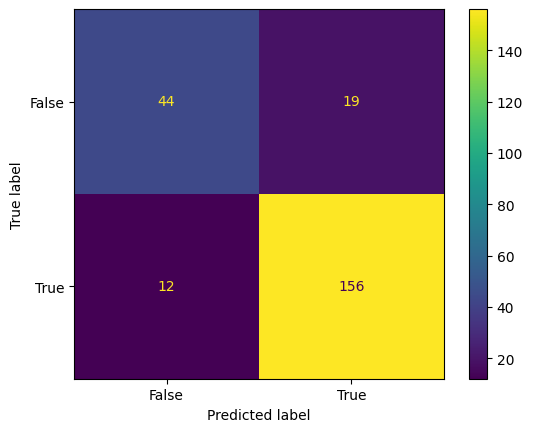

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
Epoch: 0
Train:
Accuracy = 76.08695983886719
Loss =  0.4417681396007538
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 68.0851058959961
Loss =  0.0615653944015503
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 1
Train:
Accuracy = 78.43478393554688
Loss =  0.43978118896484375
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 70.2127685546875
Loss =  0.0760687098503113
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 2
Train:
Accuracy = 77.82608795166016
Loss =  0.2674464464187622
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 71.446807861328125
Loss =  0.0758897476196289
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 3
Train:
Accuracy = 79.34782409667969
Loss =  0.0499589717388153
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 73.82978820800781
Loss =  0.0905491137504578
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 4
Train:
Accuracy = 69.02173614501953
Loss =  0.09313334703445435
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 68.0851058959961
Loss =  0.0825000047683716
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 5
Train:
Accuracy = 79.89130401611328
Loss =  0.04515164613723755
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 74.46808624267578
Loss =  0.0630729746818542
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 6
Train:
Accuracy = 79.34782409667969
Loss =  0.04311726927757263
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 75.2127685546875
Loss =  0.0756471109390259
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 7
Train:
Accuracy = 80.97826385498047
Loss =  0.03861737909317017
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 76.46808624267578
Loss =  0.0756721258163452
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 8
Train:
Accuracy = 82.06521606445312
Loss =  0.03282437086105347
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 80.2127685546875
Loss =  0.0740962195396423
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 9
Train:
Accuracy = 82.60869598388672
Loss =  0.0361334433555603
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 80.46808624267578
Loss =  0.0643580436706543
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 10
Train:
Accuracy = 82.60869598388672
Loss =  0.03515155577659607
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 80.2127685546875
Loss =  0.0710130715370178
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 11
Train:
Accuracy = 83.6363639831543
Loss =  0.03235085308551788
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 84.0
Loss =  0.06263586282730102
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 12
Train:
Accuracy = 82.60869598388672
Loss =  0.0367285430431366
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 81.70212936401367
Loss =  0.8409569263458252
<class 'torch.Tensor'> <class 'torch.Tensor'>

Epoch: 13
Train:
Accuracy = 86.41304016113281
Loss =  0.03578157210350037
<class 'torch.Tensor'> <class 'torch.Tensor'>
Test:
Accuracy = 75.82978820800781
Loss =  0.1541926622390747
<class 'torch.Tensor'> <class 'torch.Tensor'>